In [3]:
!pip install transformers datasets scikit-learn matplotlib seaborn --quiet

In [4]:
!pip install hf_transfer

  Using cached hf_transfer-0.1.9-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.7 kB)
Using cached hf_transfer-0.1.9-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)


Total Sample Size: 1600000 (Balanced Positive, Negative)
Using Device: GPU


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Using Batch Size: 128
Starting batch predictions...
Processed 0 / 1600000 samples...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 12800 / 1600000 samples...
Processed 25600 / 1600000 samples...
Processed 38400 / 1600000 samples...
Processed 51200 / 1600000 samples...
Processed 64000 / 1600000 samples...
Processed 76800 / 1600000 samples...
Processed 89600 / 1600000 samples...
Processed 102400 / 1600000 samples...
Processed 115200 / 1600000 samples...
Processed 128000 / 1600000 samples...
Processed 140800 / 1600000 samples...
Processed 153600 / 1600000 samples...
Processed 166400 / 1600000 samples...
Processed 179200 / 1600000 samples...
Processed 192000 / 1600000 samples...
Processed 204800 / 1600000 samples...
Processed 217600 / 1600000 samples...
Processed 230400 / 1600000 samples...
Processed 243200 / 1600000 samples...
Processed 256000 / 1600000 samples...
Processed 268800 / 1600000 samples...
Processed 281600 / 1600000 samples...
Processed 294400 / 1600000 samples...
Processed 307200 / 1600000 samples...
Processed 320000 / 1600000 samples...
Processed 332800 / 1600000 samples...
Processed 345600 / 

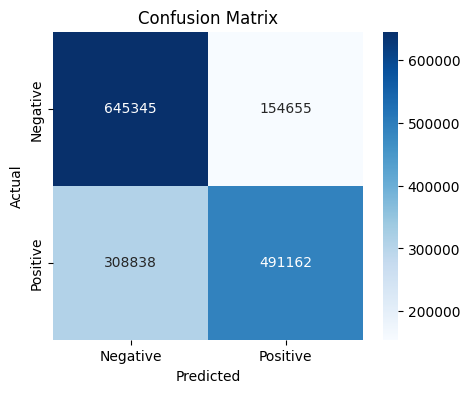

In [4]:
# Step 1: Install Dependencies (Uncomment if needed)
# !pip install datasets transformers scikit-learn matplotlib seaborn

# Step 2: Load and Prepare the Full Balanced Dataset
import pandas as pd

# Path to your Sentiment140 CSV
path="training.1600000.processed.noemoticon.csv"

# Correct column names from dataset description
cols = ["sentiment", "id", "date", "flag", "user", "text"]

# Load CSV using correct encoding and no header
df = pd.read_csv(path, encoding="latin-1", header=None, names=cols)

# Keep only Positive (4) and Negative (0) sentiments
df = df[df['sentiment'].isin([0, 4])].reset_index(drop=True)
df['label'] = df['sentiment'].map({0: 0, 4: 1})  # 0: Negative, 1: Positive

# Shuffle the dataset
sample_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

texts = sample_df['text'].tolist()
true_labels = sample_df['label'].tolist()

print(f"Total Sample Size: {len(texts)} (Balanced Positive, Negative)")

# Step 3: Load Pretrained Model with Automatic GPU Acceleration
import torch
from transformers import pipeline

device = 0 if torch.cuda.is_available() else -1
print(f"Using Device: {'GPU' if device == 0 else 'CPU'}")

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=device)

# Step 4: Dynamically Set Batch Size Based on VRAM (if GPU is available)
if device == 0:
    vram_gb = torch.cuda.get_device_properties(0).total_memory // (1024**3)
    if vram_gb >= 24:
        batch_size = 128
    elif vram_gb >= 16:
        batch_size = 64
    else:
        batch_size = 32
else:
    batch_size = 16  # Lower batch size for CPU to avoid memory issues

print(f"Using Batch Size: {batch_size}")

# Step 5: Predict in Batches and Time the Inference
import time
pred_labels = []

start_time = time.time()

print("Starting batch predictions...")
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    predictions = sentiment_pipeline(batch_texts, truncation=True, batch_size=batch_size)
    batch_preds = [0 if p['label'] == 'NEGATIVE' else 1 for p in predictions]
    pred_labels.extend(batch_preds)
    if (i // batch_size) % 100 == 0:
        print(f"Processed {i} / {len(texts)} samples...")

end_time = time.time()
print(f"Total Inference Time: {end_time - start_time:.2f} seconds")

# Step 6: Compute Errors and Report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
total_error = (fp + fn) / len(true_labels)
accuracy = (tp + tn) / len(true_labels)

print(f"\nError Analysis:")
print(f"Accuracy: {accuracy:.2%}")
print(f"False Positive Rate (FPR): {fpr:.2%}")
print(f"False Negative Rate (FNR): {fnr:.2%}")
print(f"Total Error Rate: {total_error:.2%}")

# Step 7: Visualize Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=['Negative', 'Positive'],
             yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Sentiment Classification with Neural Networks Walkthrough

In [7]:
## LOADING DATA
import pandas as pd
import torch
from collections import Counter
# Path to your Sentiment140 CSV
path="training.1600000.processed.noemoticon.csv"

# Correct column names from dataset description
cols = ["sentiment", "id", "date", "flag", "user", "text"]

# Load CSV using correct encoding and no header
df = pd.read_csv(path, encoding="latin-1", header=None, names=cols)
# Keep only Positive (4) and Negative (0) sentiments
df = df[df['sentiment'].isin([0, 4])].reset_index(drop=True)
df['label'] = df['sentiment'].map({0: 0, 4: 1})

# Ensure balanced dataset
min_class_count = min(df['label'].value_counts()[0], df['label'].value_counts()[1])
pos_samples = df[df['label'] == 1].sample(min_class_count, random_state=42)
neg_samples = df[df['label'] == 0].sample(min_class_count, random_state=42)
balanced_df = pd.concat([pos_samples, neg_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

texts = balanced_df['text'].tolist()
labels = balanced_df['label'].tolist()

print(f"Total Sample Size: {len(texts)} (Balanced Positive, Negative)")

# Step 3: Tokenization and Data Preparation
from collections import Counter
from torch.utils.data import Dataset, DataLoader

tokenized_texts = [text.lower().split() for text in texts]
all_words = [word for text in tokenized_texts for word in text]
vocab = {word: idx + 1 for idx, (word, _) in enumerate(Counter(all_words).most_common(10000))}
vocab['<PAD>'] = 0

def encode(text, max_len=50):
    ids = [vocab.get(word, 0) for word in text]
    ids = ids[:max_len] + [0] * (max_len - len(ids))
    return ids

encoded_texts = [encode(text) for text in tokenized_texts]

# Balanced Split: 80% Train, 10% Validation, 10% Test
total_samples = len(encoded_texts)
train_end = int(0.8 * total_samples)
val_end = int(0.9 * total_samples)

X_train = encoded_texts[:train_end]
y_train = labels[:train_end]

X_val = encoded_texts[train_end:val_end]
y_val = labels[train_end:val_end]

X_test = encoded_texts[val_end:]
y_test = labels[val_end:]

print(f"Train Size: {len(X_train)}")
print(f"Validation Size: {len(X_val)}")
print(f"Test Size: {len(X_test)}")

class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
print(f"Using Batch Size: {batch_size}")

train_ds = SentimentDataset(X_train, y_train)
val_ds = SentimentDataset(X_val, y_val)
test_ds = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Total Sample Size: 1600000 (Balanced Positive, Negative)
Train Size: 1280000
Validation Size: 160000
Test Size: 160000
Using Batch Size: 32


In [8]:
# Define CNN Models
import torch.nn as nn
import torch.nn.functional as F

# Baseline CNN (given version)
class CNNBaseline(nn.Module):
    def __init__(self, vocab_size, embed_dim=100):
        super(CNNBaseline, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=5)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x).squeeze(2)
        x = self.fc(x).squeeze(1)
        return torch.sigmoid(x)

# Modified CNN (assignment requirement)
class CNNModified(nn.Module):
    def __init__(self, vocab_size, embed_dim=100):
        super(CNNModified, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 256, kernel_size=7)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=5)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(2)
        x = self.fc(x).squeeze(1)
        return torch.sigmoid(x)


In [9]:
# Training Function with Validation Monitoring
import time

def train_model(model, learning_rate):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")
    patience = 3

    for epoch in range(20):
        model.train()
        total_loss = 0
        start_time = time.time()

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        end_time = time.time()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item()

                predicted = (preds > 0.5).int()
                correct += (predicted == y_batch.int()).sum().item()
                total += y_batch.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_error_rate = 1 - (correct / total)

        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Error Rate: {val_error_rate:.2%}, "
              f"Time: {end_time - start_time:.2f}s")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()
            patience = 3
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_state)
    return model



========== BASELINE CNN | LR = 0.001 ==========
Epoch 1, Train Loss: 0.6146, Val Loss: 0.5720, Val Error Rate: 30.07%, Time: 154.55s
Epoch 2, Train Loss: 0.5520, Val Loss: 0.5365, Val Error Rate: 27.34%, Time: 154.20s
Epoch 3, Train Loss: 0.5242, Val Loss: 0.5203, Val Error Rate: 26.07%, Time: 154.30s
Epoch 4, Train Loss: 0.5075, Val Loss: 0.5089, Val Error Rate: 25.25%, Time: 154.80s
Epoch 5, Train Loss: 0.4959, Val Loss: 0.5024, Val Error Rate: 24.83%, Time: 155.56s
Epoch 6, Train Loss: 0.4870, Val Loss: 0.4969, Val Error Rate: 24.42%, Time: 161.87s
Epoch 7, Train Loss: 0.4798, Val Loss: 0.4933, Val Error Rate: 24.12%, Time: 155.19s
Epoch 8, Train Loss: 0.4740, Val Loss: 0.4900, Val Error Rate: 23.88%, Time: 154.18s
Epoch 9, Train Loss: 0.4688, Val Loss: 0.4882, Val Error Rate: 23.67%, Time: 156.16s
Epoch 10, Train Loss: 0.4642, Val Loss: 0.4914, Val Error Rate: 23.88%, Time: 155.51s
Epoch 11, Train Loss: 0.4602, Val Loss: 0.4850, Val Error Rate: 23.51%, Time: 153.93s
Epoch 12, Trai

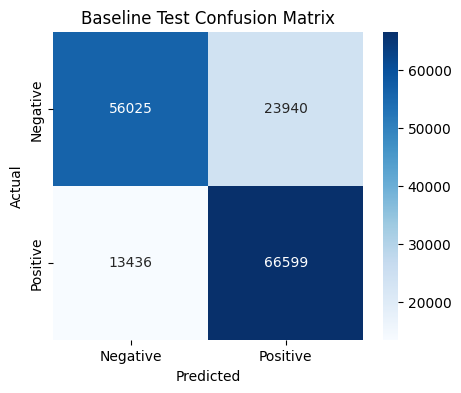


Baseline Model Parameters:
Total Parameters: 1,064,357
Trainable Parameters: 1,064,357

========== MODIFIED CNN | LR = 0.001 ==========
Epoch 1, Train Loss: 0.6580, Val Loss: 0.6249, Val Error Rate: 34.95%, Time: 181.31s
Epoch 2, Train Loss: 0.6003, Val Loss: 0.5793, Val Error Rate: 30.61%, Time: 180.59s
Epoch 3, Train Loss: 0.5596, Val Loss: 0.5461, Val Error Rate: 27.84%, Time: 181.36s
Epoch 4, Train Loss: 0.5297, Val Loss: 0.5236, Val Error Rate: 26.15%, Time: 181.11s
Epoch 5, Train Loss: 0.5079, Val Loss: 0.5093, Val Error Rate: 25.11%, Time: 181.88s
Epoch 6, Train Loss: 0.4915, Val Loss: 0.5011, Val Error Rate: 24.50%, Time: 181.38s
Epoch 7, Train Loss: 0.4783, Val Loss: 0.4945, Val Error Rate: 24.18%, Time: 180.20s
Epoch 8, Train Loss: 0.4670, Val Loss: 0.4905, Val Error Rate: 23.76%, Time: 179.42s
Epoch 9, Train Loss: 0.4571, Val Loss: 0.4848, Val Error Rate: 23.52%, Time: 181.39s
Epoch 10, Train Loss: 0.4480, Val Loss: 0.4858, Val Error Rate: 23.60%, Time: 182.21s
Epoch 11, Tr

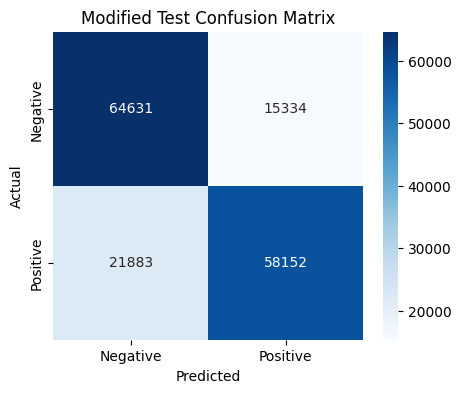


Modified Model Parameters:
Total Parameters: 1,507,749
Trainable Parameters: 1,507,749

========== BASELINE CNN | LR = 0.01 ==========
Epoch 1, Train Loss: 0.5375, Val Loss: 0.5039, Val Error Rate: 24.85%, Time: 149.68s
Epoch 2, Train Loss: 0.4879, Val Loss: 0.4918, Val Error Rate: 23.90%, Time: 151.19s
Epoch 3, Train Loss: 0.4712, Val Loss: 0.4780, Val Error Rate: 22.88%, Time: 154.58s
Epoch 4, Train Loss: 0.4607, Val Loss: 0.4856, Val Error Rate: 23.49%, Time: 153.41s
Epoch 5, Train Loss: 0.4532, Val Loss: 0.4748, Val Error Rate: 22.81%, Time: 154.89s
Epoch 6, Train Loss: 0.4474, Val Loss: 0.4874, Val Error Rate: 23.47%, Time: 154.71s
Epoch 7, Train Loss: 0.4426, Val Loss: 0.4735, Val Error Rate: 22.50%, Time: 154.92s
Epoch 8, Train Loss: 0.4388, Val Loss: 0.4721, Val Error Rate: 22.38%, Time: 156.11s
Epoch 9, Train Loss: 0.4353, Val Loss: 0.4727, Val Error Rate: 22.37%, Time: 154.75s
Epoch 10, Train Loss: 0.4325, Val Loss: 0.4741, Val Error Rate: 22.29%, Time: 156.37s
Epoch 11, Tra

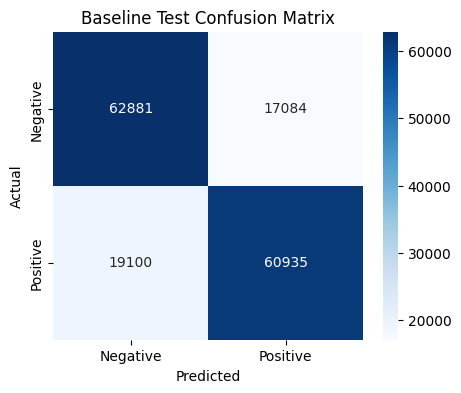


Baseline Model Parameters:
Total Parameters: 1,064,357
Trainable Parameters: 1,064,357

========== MODIFIED CNN | LR = 0.01 ==========
Epoch 1, Train Loss: 0.5569, Val Loss: 0.5025, Val Error Rate: 24.87%, Time: 181.80s
Epoch 2, Train Loss: 0.4818, Val Loss: 0.4813, Val Error Rate: 23.23%, Time: 182.75s
Epoch 3, Train Loss: 0.4499, Val Loss: 0.4835, Val Error Rate: 23.06%, Time: 184.16s
Epoch 4, Train Loss: 0.4264, Val Loss: 0.4666, Val Error Rate: 22.09%, Time: 183.90s
Epoch 5, Train Loss: 0.4060, Val Loss: 0.4856, Val Error Rate: 22.72%, Time: 184.34s
Epoch 6, Train Loss: 0.3870, Val Loss: 0.4864, Val Error Rate: 22.67%, Time: 185.30s
Epoch 7, Train Loss: 0.3688, Val Loss: 0.5283, Val Error Rate: 24.31%, Time: 181.95s
Early stopping triggered.

Modified Test Set Error Analysis:
Accuracy: 75.77%
False Positive Rate (FPR): 35.63%
False Negative Rate (FNR): 12.84%
Total Error Rate: 24.23%


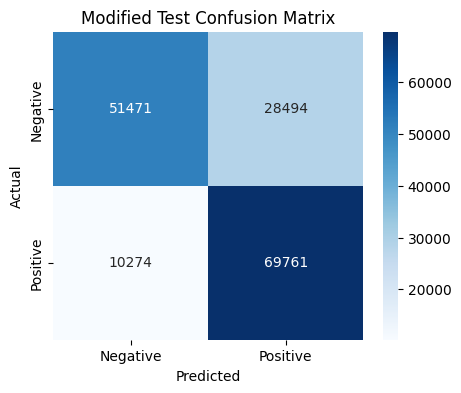


Modified Model Parameters:
Total Parameters: 1,507,749
Trainable Parameters: 1,507,749

========== BASELINE CNN | LR = 0.1 ==========
Epoch 1, Train Loss: 0.5554, Val Loss: 0.5133, Val Error Rate: 24.87%, Time: 156.18s
Epoch 2, Train Loss: 0.5048, Val Loss: 0.5002, Val Error Rate: 23.85%, Time: 156.87s
Epoch 3, Train Loss: 0.4859, Val Loss: 0.4869, Val Error Rate: 22.81%, Time: 155.08s
Epoch 4, Train Loss: 0.4733, Val Loss: 0.4795, Val Error Rate: 22.36%, Time: 153.96s
Epoch 5, Train Loss: 0.4643, Val Loss: 0.4771, Val Error Rate: 22.25%, Time: 154.33s
Epoch 6, Train Loss: 0.4567, Val Loss: 0.4939, Val Error Rate: 22.59%, Time: 155.17s
Epoch 7, Train Loss: 0.4507, Val Loss: 0.4753, Val Error Rate: 21.82%, Time: 151.04s
Epoch 8, Train Loss: 0.4449, Val Loss: 0.4839, Val Error Rate: 21.86%, Time: 152.52s
Epoch 9, Train Loss: 0.4403, Val Loss: 0.4720, Val Error Rate: 21.66%, Time: 156.44s
Epoch 10, Train Loss: 0.4360, Val Loss: 0.4737, Val Error Rate: 21.64%, Time: 160.80s
Epoch 11, Trai

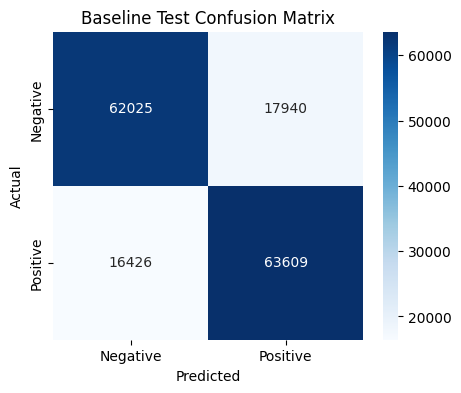


Baseline Model Parameters:
Total Parameters: 1,064,357
Trainable Parameters: 1,064,357

========== MODIFIED CNN | LR = 0.1 ==========
Epoch 1, Train Loss: 0.5272, Val Loss: 0.4794, Val Error Rate: 23.09%, Time: 188.79s
Epoch 2, Train Loss: 0.4655, Val Loss: 0.4637, Val Error Rate: 22.04%, Time: 184.04s
Epoch 3, Train Loss: 0.4405, Val Loss: 0.4601, Val Error Rate: 21.55%, Time: 182.36s
Epoch 4, Train Loss: 0.4220, Val Loss: 0.4628, Val Error Rate: 21.86%, Time: 190.17s
Epoch 5, Train Loss: 0.4062, Val Loss: 0.4743, Val Error Rate: 21.63%, Time: 189.63s
Epoch 6, Train Loss: 0.3917, Val Loss: 0.4805, Val Error Rate: 21.86%, Time: 181.00s
Early stopping triggered.

Modified Test Set Error Analysis:
Accuracy: 78.13%
False Positive Rate (FPR): 26.39%
False Negative Rate (FNR): 17.36%
Total Error Rate: 21.87%


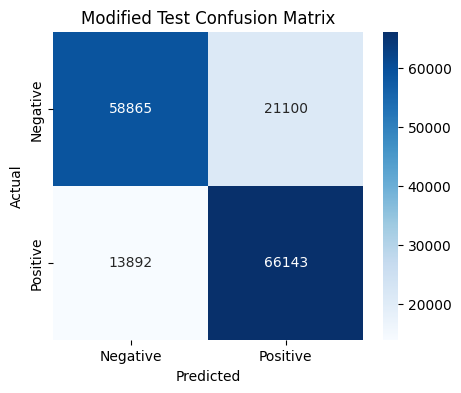


Modified Model Parameters:
Total Parameters: 1,507,749
Trainable Parameters: 1,507,749

==================== FINAL RESULTS TABLE ====================

       Model  Learning Rate  Test Accuracy
Baseline CNN          0.001       0.766400
Modified CNN          0.001       0.767394
Baseline CNN          0.010       0.773850
Modified CNN          0.010       0.757700
Baseline CNN          0.100       0.785212
Modified CNN          0.100       0.781300


In [14]:
# Evaluation Function

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 7: Evaluation Function (Returns Accuracy)
def evaluate(model, loader, dataset_name="Test"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch)
            preds = (preds > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    total_error = (fp + fn) / len(all_labels)
    accuracy = 1 - total_error

    print(f"\n{dataset_name} Set Error Analysis:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"False Positive Rate (FPR): {fpr:.2%}")
    print(f"False Negative Rate (FNR): {fnr:.2%}")
    print(f"Total Error Rate: {total_error:.2%}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['Negative', 'Positive'],
                 yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    return accuracy   # <-- REQUIRED FOR YOUR RESULTS TABLE


# Step 8: Count Parameters (YOUR EXACT FUNCTION)
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

# Run All Experiments Required by Assignment

learning_rates = [0.001, 0.01, 0.1]
results = []

for lr in learning_rates:

    # BASELINE
    print(f"\n========== BASELINE CNN | LR = {lr} ==========")
    base_model = CNNBaseline(len(vocab))
    base_model = train_model(base_model, lr)
    test_acc = evaluate(base_model, test_loader, dataset_name="Baseline Test")

    print("\nBaseline Model Parameters:")
    count_parameters(base_model)

    results.append({
        "Model": "Baseline CNN",
        "Learning Rate": lr,
        "Test Accuracy": test_acc
    })

    # MODIFIED
    print(f"\n========== MODIFIED CNN | LR = {lr} ==========")
    mod_model = CNNModified(len(vocab))
    mod_model = train_model(mod_model, lr)
    test_acc = evaluate(mod_model, test_loader, dataset_name="Modified Test")

    print("\nModified Model Parameters:")
    count_parameters(mod_model)

    results.append({
        "Model": "Modified CNN",
        "Learning Rate": lr,
        "Test Accuracy": test_acc
    })

# FINAL RESULTS TABLE
df_results = pd.DataFrame(results)
print("\n==================== FINAL RESULTS TABLE ====================\n")
print(df_results.to_string(index=False))

Vocabulary Size (including <PAD>): 10001


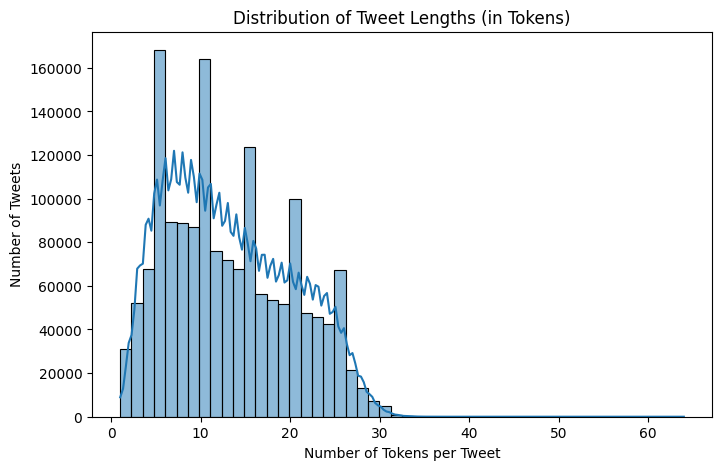

Average Tweet Length (in tokens): 13.18
Median Tweet Length (in tokens): 12.0
Max Tweet Length (in tokens): 64
Min Tweet Length (in tokens): 1
Tweets Exceeding Max Sequence Length (50 tokens): 3 (0.00%)

Sample Positive Tweets:
1. whoo the party was funfunfun!  had a great time.
2. Playing with new strings 
3. guess who's birthday is tomorrow!  oh probably the same girl who's best friend is getting home tomorrow...woooooooo 
4. @Huynhtmx looool sike... 1 more year Maria one more year! 
5. just what every businessman needs most  ? http://blip.fm/~4mfxr
6. @davidismyangel omg Sirius!!  i love when you find out he's innocent!
7. just played 500 i won 625 ) YAY ME 
8. @amymphillips   welcome to twitter ames.. my original &quot;welcome to twitter&quot; had too many L's in your last name 
9. is loving Look How I'm Doing, Heidi Montags new song  can't wait for the album Heidi!
10. @aschmitt hummm a little legal problem  if I recall  http://bit.ly/rg7xg

Sample Negative Tweets:
1.  company is 

In [15]:

# Path to your Sentiment140 CSV
path="training.1600000.processed.noemoticon.csv"

# Correct column names from dataset description
cols = ["sentiment", "id", "date", "flag", "user", "text"]

# Load CSV using correct encoding and no header
df = pd.read_csv(path, encoding="latin-1", header=None, names=cols)

# Keep only Positive (4) and Negative (0) sentiments
df = df[df['sentiment'].isin([0, 4])].reset_index(drop=True)
df['label'] = df['sentiment'].map({0: 0, 4: 1})  # 0: Negative, 1: Positive

# Shuffle the dataset
sample_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate and Display Vocabulary Size (Including <PAD>)
print(f"Vocabulary Size (including <PAD>): {len(vocab)}")

# Calculate Number of Tokens per Tweet (Tweet Length in Tokens)
tweet_token_counts = [len(tokens) for tokens in tokenized_texts]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot Distribution of Tweet Lengths (Measured in Tokens)
plt.figure(figsize=(8, 5))
sns.histplot(tweet_token_counts, bins=50, kde=True)
plt.title("Distribution of Tweet Lengths (in Tokens)")
plt.xlabel("Number of Tokens per Tweet")
plt.ylabel("Number of Tweets")
plt.show()

# Basic Statistics About Tweet Lengths
average_tokens_per_tweet = np.mean(tweet_token_counts)
median_tokens_per_tweet = np.median(tweet_token_counts)
max_tokens_in_tweet = np.max(tweet_token_counts)
min_tokens_in_tweet = np.min(tweet_token_counts)

print(f"Average Tweet Length (in tokens): {average_tokens_per_tweet:.2f}")
print(f"Median Tweet Length (in tokens): {median_tokens_per_tweet}")
print(f"Max Tweet Length (in tokens): {max_tokens_in_tweet}")
print(f"Min Tweet Length (in tokens): {min_tokens_in_tweet}")

# How Many Tweets Exceed the Maximum Sequence Length Used for Padding/Truncation?
max_sequence_length = 50  # Typically used in model input preparation
tweets_exceeding_max_length = sum(length > max_sequence_length for length in tweet_token_counts)
percentage_exceeding = (tweets_exceeding_max_length / len(tweet_token_counts)) * 100

print(f"Tweets Exceeding Max Sequence Length ({max_sequence_length} tokens): "
      f"{tweets_exceeding_max_length} ({percentage_exceeding:.2f}%)")

print("\nSample Positive Tweets:")
positive_tweets = sample_df[sample_df['label'] == 1]['text'].sample(10, random_state=42).tolist()
for idx, tweet in enumerate(positive_tweets, 1):
    print(f"{idx}. {tweet}")

print("\nSample Negative Tweets:")
negative_tweets = sample_df[sample_df['label'] == 0]['text'].sample(10, random_state=42).tolist()
for idx, tweet in enumerate(negative_tweets, 1):
    print(f"{idx}. {tweet}")

